<h4>In this notebook we will work with transformed data</h4>

In [1]:
from typing import *
from pathlib import Path
from tqdm import tqdm


import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings("ignore")


ROOT_DIR = Path(os.getcwd()).parent.parent

In [2]:
df = pd.read_parquet(
    os.path.join(ROOT_DIR, "data/datasets/train_14_06_2.parquet")
)

df = df.reset_index(drop=True)
df["pump_hash"] = df["pumped_ticker"] + df["pump_time"]
df.shape

(39848, 141)

In [3]:
df.isna().sum().sort_values()

overall_return_1h                        0
log_return_std_336h_30d                  0
log_return_skew_336h                     0
volume_quote_long_share_336h             0
num_trades_long_share_336h               0
                                      ... 
quote_slippage_imbalance_ratio_12h     277
quote_abs_kurt_1h_30d                  485
quote_slippage_imbalance_ratio_6h      604
quote_slippage_imbalance_ratio_3h     1266
quote_slippage_imbalance_ratio_1h     3976
Length: 141, dtype: int64

In [4]:
df = df.replace(np.inf, np.nan)
df = df.replace(-np.inf, np.nan)

In [5]:
df = df.drop(
    columns=["quote_slippage_imbalance_ratio_1h"]
)

In [6]:
reg_cols: List[str] = df.columns[:-7]

categorical_cols: List[str] = [
    "num_prev_pumps", 
]

num_cols: List[str] = list(set(reg_cols) - set(categorical_cols))

In [7]:
# skip pump if any variable is missing
df_pumps = pd.DataFrame()

for pump_hash, df_pump in df.groupby("pump_hash"):
    # if any feature is missing for the pump observation, then there is no point to fill it with median value
    if any(df_pump[df_pump["is_pumped"]].isna().any()):
        continue
    # otherwise fill other cols with median
    for col in num_cols:
        col_median: float = df_pump[col].median()
        df_pump[col] = df_pump[col].fillna(col_median)

    df_pumps = pd.concat([df_pumps, df_pump])

<h4>Plot distributions of features</h4>

In [8]:
pumps_plot: np.array = np.random.choice(df_pumps["pump_hash"].unique(), 10, replace=False)
df_plot: pd.DataFrame = df_pumps[df_pumps["pump_hash"].isin(pumps_plot)].copy()

100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


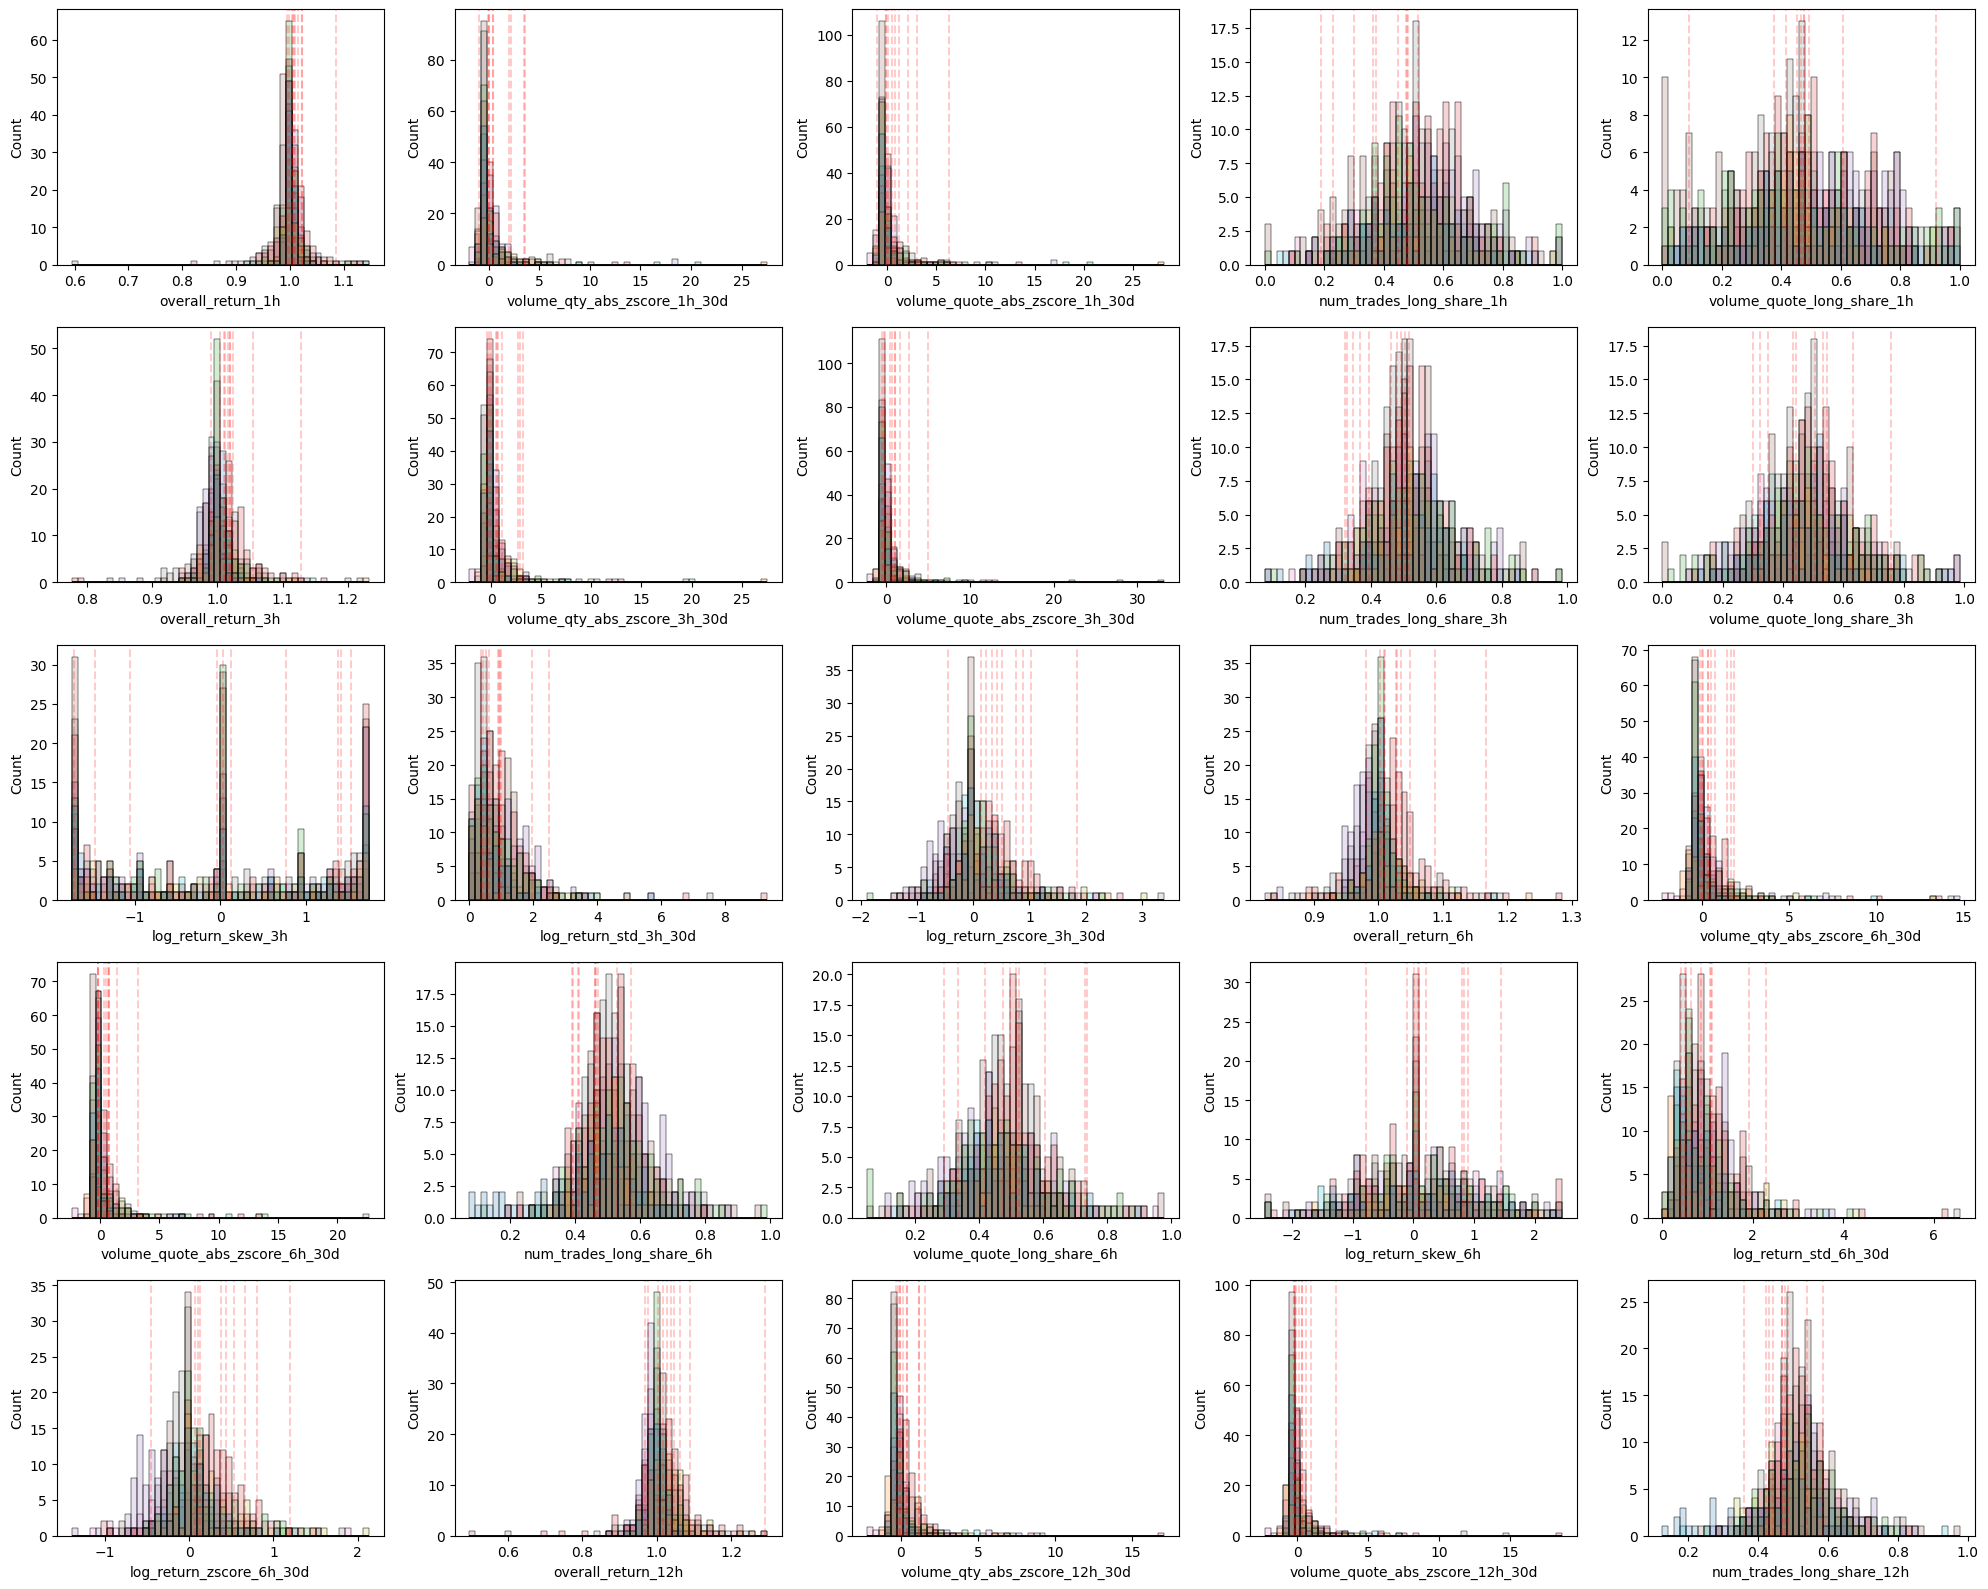

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(20, 16))
axs = [el for ax in axs for el in ax]

for col, ax in tqdm(zip(reg_cols[:25], axs), total=25):
    sns.histplot(
        data=df_plot, x=col, hue="pump_hash", ax=ax, legend=False, alpha=.2, bins=50
    )

    for pump_hash in pumps_plot:
        pumped_ticker: pd.Series = (
            (df_plot["pump_hash"] == pump_hash) & (df_plot["is_pumped"])
        )
        ax.axvline(
            x=df_plot[pumped_ticker][col].iloc[-1], color="red", linestyle="--", alpha=.2
        )

plt.tight_layout()

<h4>Perform crosssectional normalization for numeric features</h4>

In [10]:
df_scaled: pd.DataFrame = pd.DataFrame()

for pump_hash, df_pump in tqdm(df_pumps.groupby("pump_hash")):
    # Scale each pump by its crosssection
    for col in num_cols:
        df_pump[col] = (df_pump[col] - df_pump[col].mean()) / df_pump[col].std()

    df_scaled = pd.concat([df_scaled, df_pump])

df_scaled.head(2)

100%|██████████| 349/349 [00:13<00:00, 25.45it/s]


,overall_return_1h,volume_qty_abs_zscore_1h_30d,volume_quote_abs_zscore_1h_30d,num_trades_long_share_1h,volume_quote_long_share_1h,overall_return_3h,volume_qty_abs_zscore_3h_30d,volume_quote_abs_zscore_3h_30d,num_trades_long_share_3h,volume_quote_long_share_3h,...,quote_abs_powerlaw_alpha_72h,quote_abs_kurt_72h_30d,num_prev_pumps,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash
10859,-0.011500,-0.238060,-0.213028,0.053803,-1.398087,0.128068,-0.011452,-0.021406,0.157610,1.015828,...,-1.083986,1.623295,1,binance,ADXBTC,2019-07-05 17:00:00,POWRBTC,False,611,ADXBTC2019-07-05 17:00:00
10860,-0.444179,-0.447109,-0.370362,0.220069,-1.132008,0.437916,-0.614615,-0.516197,-0.809509,-0.795369,...,-0.656188,0.961010,0,binance,ADXBTC,2019-07-05 17:00:00,DLTBTC,False,602,ADXBTC2019-07-05 17:00:00


100%|██████████| 25/25 [00:04<00:00,  5.34it/s]


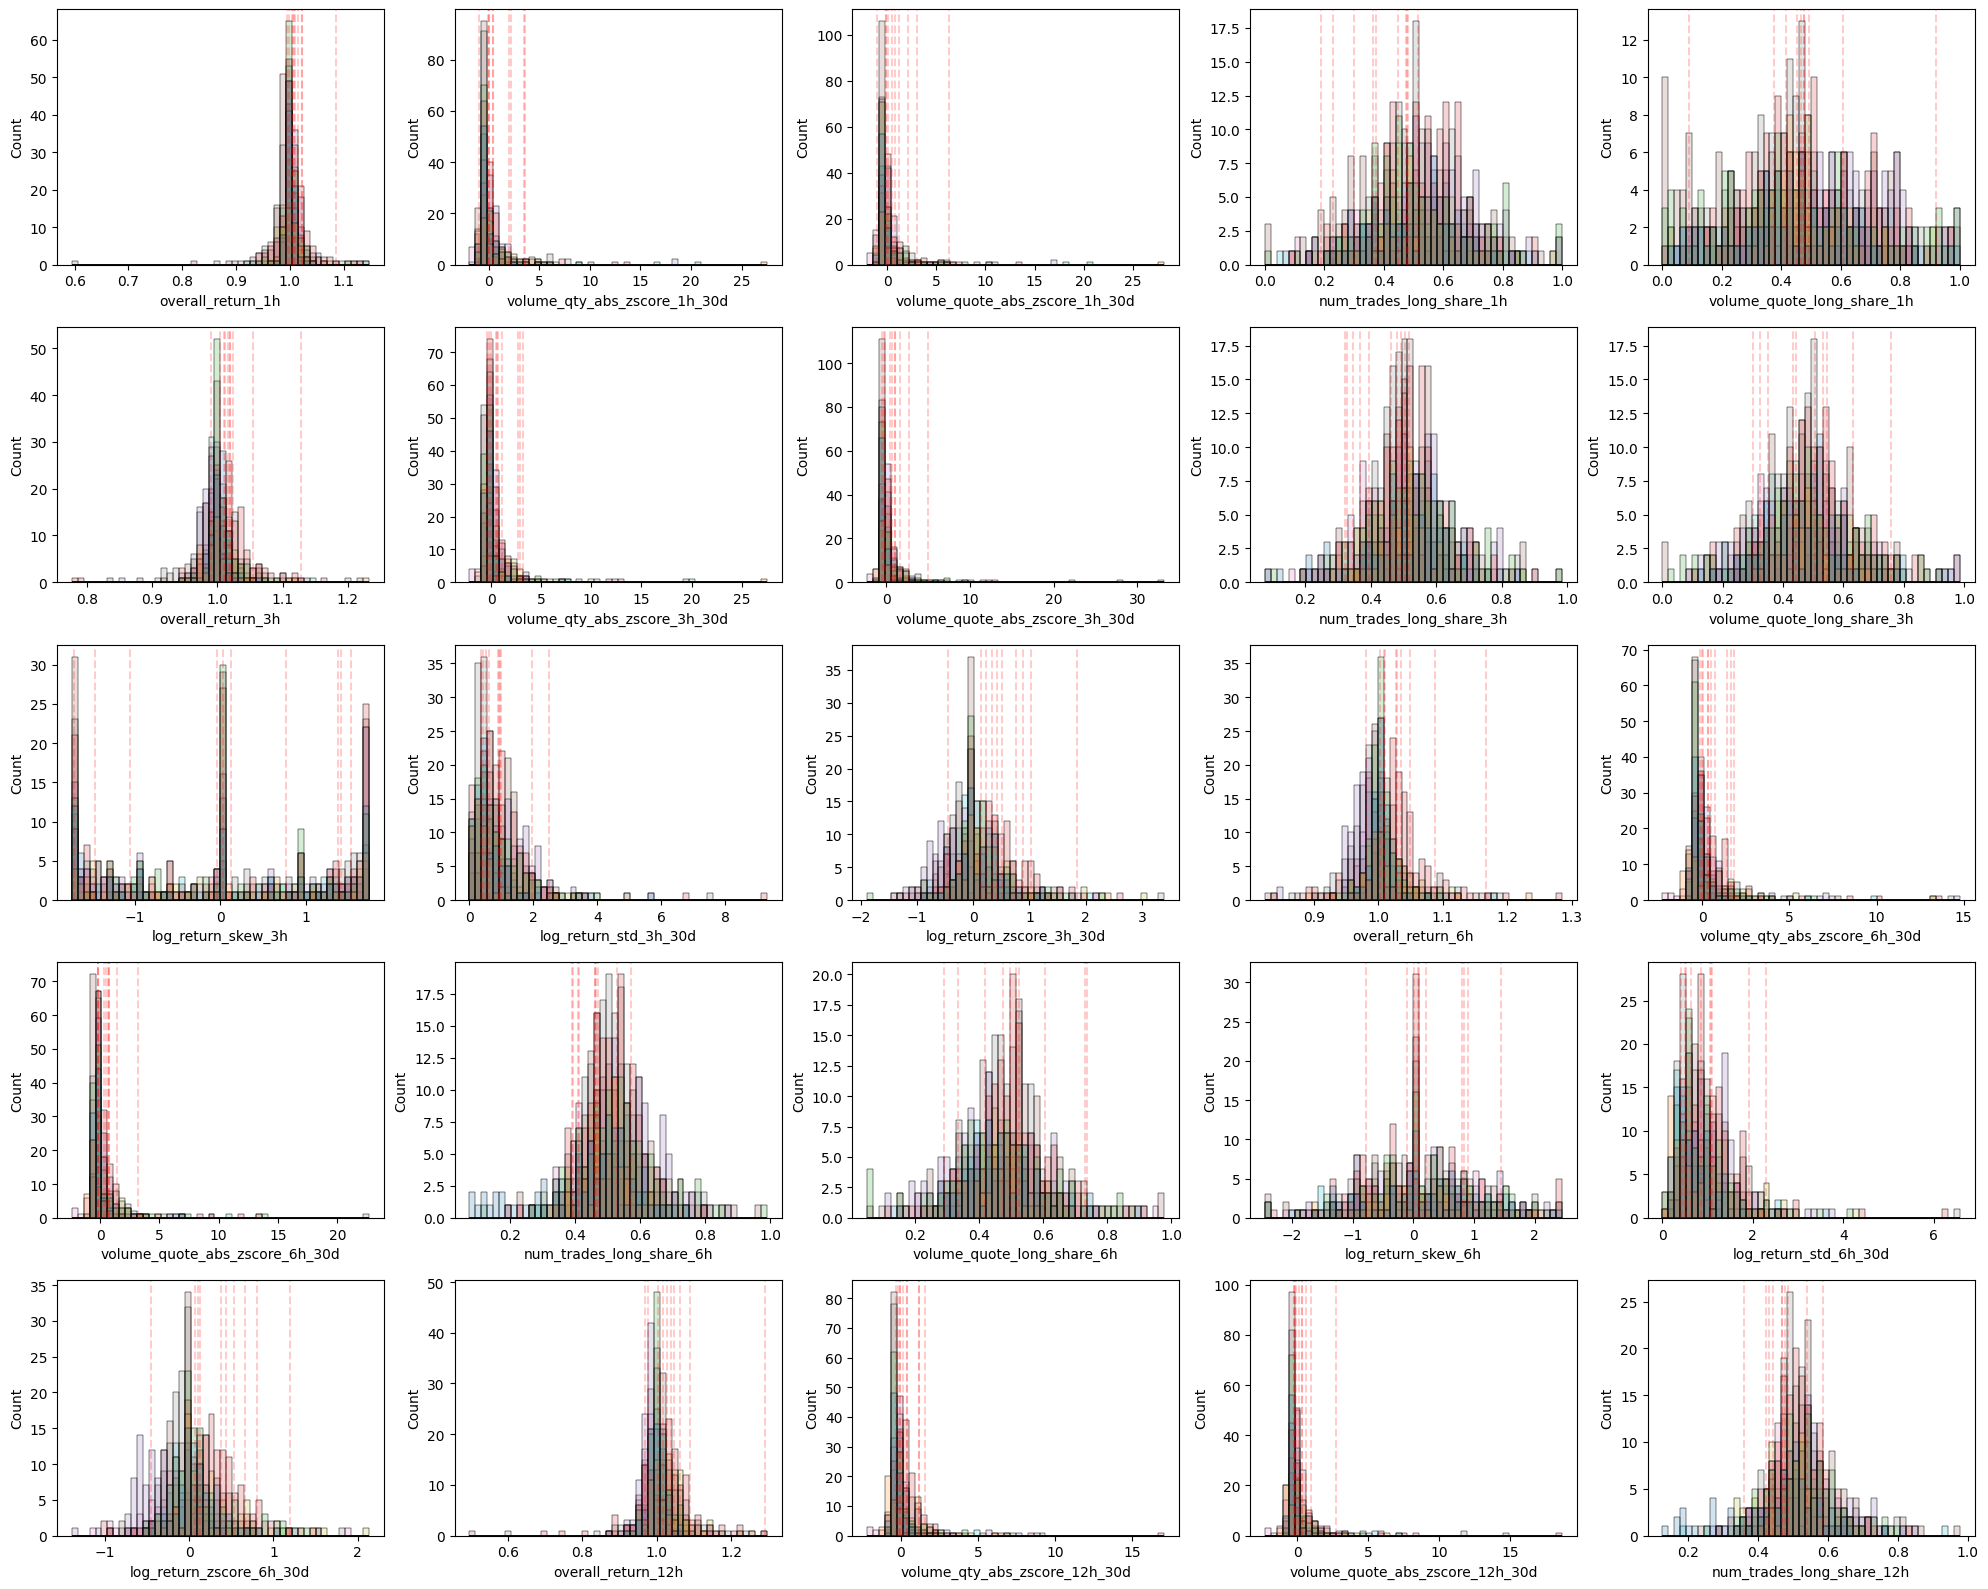

In [11]:
# plot scaled distributions
df_plot_scaled = df_plot[df_plot["pump_hash"].isin(pumps_plot)].copy()

fig, axs = plt.subplots(5, 5, figsize=(20, 16))
axs = [el for ax in axs for el in ax]

for col, ax in tqdm(zip(reg_cols[:25], axs), total=25):
    sns.histplot(
        data=df_plot_scaled, x=col, hue="pump_hash", ax=ax, legend=False, alpha=.2, bins=50
    )

    for pump_hash in pumps_plot:
        pumped_ticker: pd.Series = (
            (df_plot_scaled["pump_hash"] == pump_hash) & (df_plot_scaled["is_pumped"])
        )
        ax.axvline(
            x=df_plot_scaled[pumped_ticker][col].iloc[-1], color="red", linestyle="--", alpha=.2
        )

plt.tight_layout()

<h4>Training XGBoostClassifier</h4>

In [12]:
# train test split

df_train = df_scaled[df_scaled["pump_time"] < "2021-01-01"].copy()
df_test = df_scaled[df_scaled["pump_time"] >= "2021-01-01"].copy()

df_train["is_pumped"].value_counts(), df_test["is_pumped"].value_counts()

(is_pumped
 False    29476
 True       296
 Name: count, dtype: int64,
 is_pumped
 False    9646
 True       53
 Name: count, dtype: int64)

In [13]:
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, KFold
from sklearn.metrics import f1_score, precision_recall_curve, auc
from functools import partial

import xgboost as xgb
import optuna
import gc


reg_cols: List[str] = num_cols + categorical_cols

dtrain = xgb.DMatrix(data=df_train[reg_cols], label=df_train["is_pumped"])
dtest = xgb.DMatrix(data=df_test[reg_cols], label=df_test["is_pumped"])

In [14]:
def xgboost_objective(
    trial: optuna.Trial, df: pd.DataFrame, reg_cols: List[str], target: str, fold: TimeSeriesSplit
) -> float:
    
    xgb_params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss"],
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 500),
    }

    auc_scores = []
    
    i = 0
    
    for train_idx, val_idx in fold.split(df[reg_cols], df[target]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        dtrain = xgb.DMatrix(df_train[reg_cols], label=df_train[target])
        dval = xgb.DMatrix(df_val[reg_cols], label=df_val[target])
        
        evals_result = {}
        
        # Fit the model with early stopping
        model = xgb.train(
            xgb_params, dtrain=dtrain, 
            evals=[(dtrain, "train"), (dval, "val")],
            num_boost_round=3000, early_stopping_rounds=10,
            verbose_eval=False, evals_result=evals_result
        )
        
        y_proba = model.predict(dval)
        precision, recall, _ = precision_recall_curve(y_true=df_val["is_pumped"], probas_pred=y_proba)
        prauc = auc(recall, precision)
        
        auc_scores.append(prauc)
        
        trial.report(prauc, i)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        del model, dtrain, dval
        _ = gc.collect()
        
        i += 1

    return np.mean(auc_scores)

In [15]:
fold = TimeSeriesSplit(n_splits=5)

study_xgboost = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)

study_xgboost.optimize(
    partial(xgboost_objective, df=df_train, reg_cols=num_cols, target="is_pumped", fold=fold), 
    n_trials=10
)

[I 2024-06-15 01:18:31,644] A new study created in memory with name: no-name-26087875-b231-4e20-9460-070b1d151171
[I 2024-06-15 01:18:56,582] Trial 0 finished with value: 0.024623458845925185 and parameters: {'learning_rate': 0.022622666201418118, 'max_depth': 10, 'scale_pos_weight': 441.8066953837246}. Best is trial 0 with value: 0.024623458845925185.
[I 2024-06-15 01:19:03,229] Trial 1 finished with value: 0.024156809528491176 and parameters: {'learning_rate': 0.07854165714544042, 'max_depth': 6, 'scale_pos_weight': 127.63630635239298}. Best is trial 0 with value: 0.024623458845925185.
[I 2024-06-15 01:19:26,379] Trial 2 finished with value: 0.029459313796221187 and parameters: {'learning_rate': 0.021914856366006052, 'max_depth': 5, 'scale_pos_weight': 108.0464534009198}. Best is trial 2 with value: 0.029459313796221187.
[I 2024-06-15 01:19:32,610] Trial 3 finished with value: 0.027820623753599956 and parameters: {'learning_rate': 0.11639021357978172, 'max_depth': 10, 'scale_pos_weig

In [16]:
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss"]
}

xgb_params.update(study_xgboost.best_params)

In [17]:
train, val = (
    df_pumps[df_pumps["pump_time"] <= "2020-05-01"].copy(),
    df_pumps[(df_pumps["pump_time"] > "2020-05-01") & (df_pumps["pump_time"] < "2021-01-01")].copy()
)

train["is_pumped"].value_counts(), val["is_pumped"].value_counts()

dtrain = xgb.DMatrix(data=train[reg_cols], label=train["is_pumped"])
dval = xgb.DMatrix(data=val[reg_cols], label=val["is_pumped"])

In [18]:
# train with early stopping on validation set
evals_result = {}

model = xgb.train(
    xgb_params, dtrain=dtrain, 
    evals=[(dtrain, "train"), (dval, "val")],
    num_boost_round=1000, early_stopping_rounds=5,
    verbose_eval=False, evals_result=evals_result
)

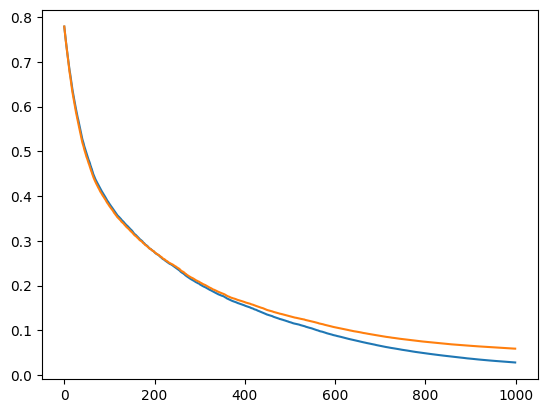

In [19]:
plt.plot(evals_result["train"]["logloss"])
plt.plot(evals_result["val"]["logloss"])

plt.show()

In [20]:
y_proba = model.predict(dtest)
y_pred = (y_proba >= 0.5).astype(int)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true=df_test["is_pumped"], y_pred=y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      9646
        True       0.00      0.00      0.00        53

    accuracy                           0.99      9699
   macro avg       0.50      0.50      0.50      9699
weighted avg       0.99      0.99      0.99      9699



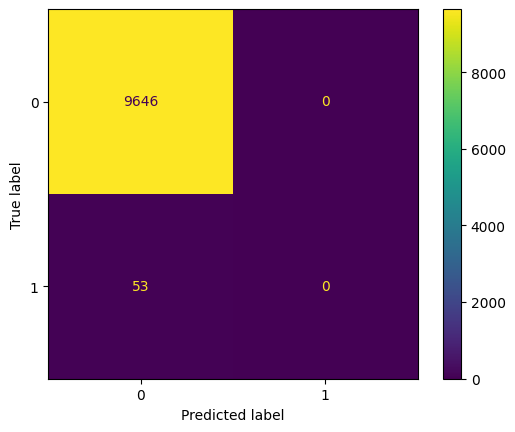

In [22]:
cm = confusion_matrix(y_true=df_test["is_pumped"], y_pred=y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

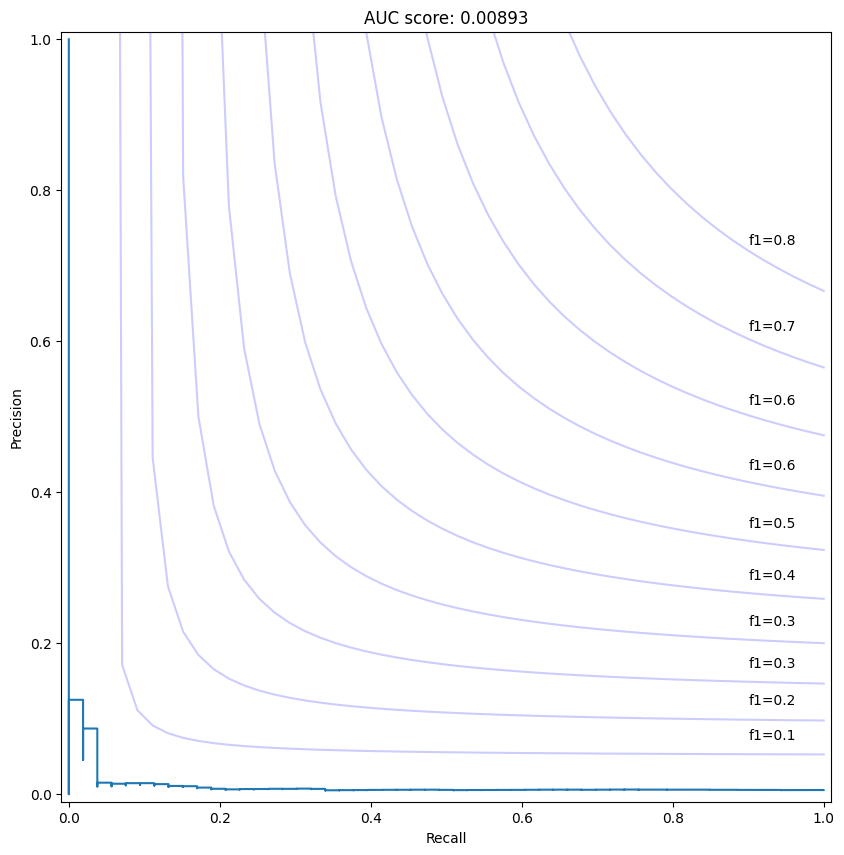

In [23]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_true=df_test["is_pumped"], probas_pred=y_proba)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

PrecisionRecallDisplay(
    precision=precision, recall=recall
).plot(ax=ax)

f_scores = np.linspace(0.1, 0.8, num=10)
lines, labels = [], []

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
    ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

plt.title(f"AUC score: {round(auc(recall, precision), 5)}")
plt.show()

In [24]:
# TOP-K metric
df_test["proba"] = y_proba

top_k_vals = []

for K in [1, 3, 5, 10, 20, 30]: 

    top_k: List[bool] = []

    for pump_hash, df_pump in df_test.groupby("pump_hash"):
        df_pump = df_pump.sort_values(by="proba", ascending=False)
        top_k_contains_pump: bool = df_pump.iloc[:K]["is_pumped"].any()
        top_k.append(top_k_contains_pump)

    top_k_vals.append(
        sum(top_k) / len(top_k)
    )
        
pd.DataFrame({
    "HR": [1, 3, 5, 10, 20, 30],
    "XGBoost model": top_k_vals
}).set_index("HR")

,XGBoost model
HR,
1,0.037736
3,0.056604
5,0.094340
10,0.132075
20,0.188679
30,0.226415


In [25]:
from catboost import Pool, CatBoostClassifier


def catboost_objective(
    trial: optuna.Trial, df: pd.DataFrame, reg_cols: List[str], 
    target: str, fold: TimeSeriesSplit, categorical_cols: List[str]
) -> float:
    
    params = {
        "objective": "Logloss",
        "eval_metric": "Logloss",
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        "class_weights": [1, trial.suggest_float("scale_pos_weight", 1, 500)],
    }

    auc_scores = []
    
    i = 0
    
    for train_idx, val_idx in fold.split(df[reg_cols], df[target]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        train = Pool(data=df_train[reg_cols], label=df_train[target], cat_features=categorical_cols)
        val = Pool(data=df_val[reg_cols], label=df_val[target], cat_features=categorical_cols)
        
        # Fit the model with early stopping
        model = CatBoostClassifier(
            **params, 
            task_type="GPU",
            devices="0",
            iterations=3000,
            early_stopping_rounds=20,
            use_best_model=True,
            verbose=False,
        )

        model.fit(train, eval_set=val)
        
        y_proba = model.predict_proba(val)[:, 1]

        precision, recall, _ = precision_recall_curve(y_true=df_val["is_pumped"], probas_pred=y_proba)
        prauc = auc(recall, precision)

        # get the best auc_score validation set
        auc_scores.append(prauc)
        
        trial.report(prauc, i)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        del model, train, val
        _ = gc.collect()
        
        i += 1

    return np.mean(auc_scores)

In [26]:
study_catboost = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)

study_catboost.optimize(
    partial(
        catboost_objective, df=df_train, 
        reg_cols=reg_cols, target="is_pumped", 
        fold=fold, categorical_cols=["num_prev_pumps"]
    ), 
    n_trials=10
)

[I 2024-06-15 01:20:46,457] A new study created in memory with name: no-name-b1a38dbf-fe13-4b2d-ad17-868b7aae8c7d
[I 2024-06-15 01:21:04,934] Trial 0 finished with value: 0.03758528103186297 and parameters: {'learning_rate': 0.0421412080385576, 'max_depth': 3, 'scale_pos_weight': 164.16222384773835}. Best is trial 0 with value: 0.03758528103186297.
[I 2024-06-15 01:21:17,089] Trial 1 finished with value: 0.1940475961961212 and parameters: {'learning_rate': 0.19088704937664508, 'max_depth': 3, 'scale_pos_weight': 423.28477783371375}. Best is trial 1 with value: 0.1940475961961212.
[I 2024-06-15 01:22:17,850] Trial 2 finished with value: 0.1230894502451378 and parameters: {'learning_rate': 0.014205335205030374, 'max_depth': 10, 'scale_pos_weight': 479.46284562573004}. Best is trial 1 with value: 0.1940475961961212.
[I 2024-06-15 01:22:38,109] Trial 3 finished with value: 0.05538009701110236 and parameters: {'learning_rate': 0.07605073175678773, 'max_depth': 8, 'scale_pos_weight': 284.393

In [27]:
train, val = (
    df_scaled[df_scaled["pump_time"] <= "2021-01-01"].copy(),
    df_scaled[(df_scaled["pump_time"] > "2021-01-01") & (df_scaled["pump_time"] <= "2021-05-01")].copy()
)

train["is_pumped"].value_counts(), val["is_pumped"].value_counts()

train = Pool(data=train[reg_cols], label=train["is_pumped"], cat_features=["num_prev_pumps"])
val = Pool(data=val[reg_cols], label=val["is_pumped"], cat_features=["num_prev_pumps"])
test = Pool(data=df_test[reg_cols], label=df_test["is_pumped"], cat_features=["num_prev_pumps"])

In [28]:
study_catboost.best_params

{'learning_rate': 0.19088704937664508,
 'max_depth': 3,
 'scale_pos_weight': 423.28477783371375}

In [29]:
cb_params = {
    "objective": "Logloss",
    "eval_metric": "Logloss",
    "task_type": "GPU"
}

cb_params.update(study_catboost.best_params)
cb_params["class_weights"] = [1, study_catboost.best_params["scale_pos_weight"]]

del cb_params["scale_pos_weight"]

model = CatBoostClassifier(
    **cb_params, iterations=3000, early_stopping_rounds=20,
    use_best_model=True, verbose=10,
)

model.fit(train, eval_set=val)

0:	learn: 0.5931226	test: 0.5849708	best: 0.5849708 (0)	total: 46ms	remaining: 2m 18s
10:	learn: 0.3806328	test: 0.5488862	best: 0.5145415 (4)	total: 805ms	remaining: 3m 38s
20:	learn: 0.3602434	test: 0.5537971	best: 0.5145415 (4)	total: 1.48s	remaining: 3m 29s
bestTest = 0.5145414927
bestIteration = 4
Shrink model to first 5 iterations.


In [30]:
y_proba = model.predict_proba(test)
y_pred = y_proba[:, 1] >= 0.5


print(
    classification_report(y_true=df_test["is_pumped"], y_pred=y_pred)
)

              precision    recall  f1-score   support

       False       1.00      0.17      0.29      9646
        True       0.01      0.92      0.01        53

    accuracy                           0.17      9699
   macro avg       0.50      0.55      0.15      9699
weighted avg       0.99      0.17      0.28      9699



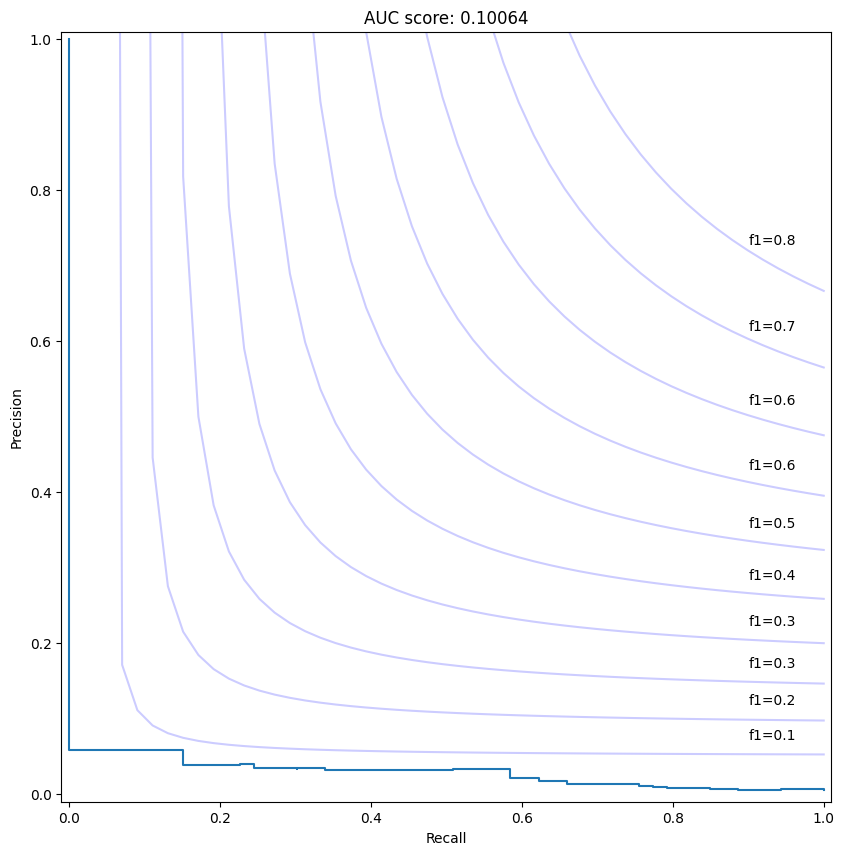

In [31]:
precision, recall, thresholds = precision_recall_curve(y_true=df_test["is_pumped"], probas_pred=y_proba[:, 1])

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

PrecisionRecallDisplay(
    precision=precision, recall=recall
).plot(ax=ax)

f_scores = np.linspace(0.1, 0.8, num=10)
lines, labels = [], []

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
    ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

plt.title(f"AUC score: {round(auc(recall, precision), 5)}")
plt.show()

In [32]:
# TOP-K metric
df_test["proba"] = y_proba[:, 1]
top_k_vals = []

for K in [1, 3, 5, 10, 20, 30]: 

    top_k: List[bool] = []

    for pump_hash, df_pump in df_test.groupby("pump_hash"):
        df_pump = df_pump.sort_values(by="proba", ascending=False)
        top_k_contains_pump: bool = df_pump.iloc[:K]["is_pumped"].any()
        top_k.append(top_k_contains_pump)

    top_k_vals.append(
        sum(top_k) / len(top_k)
    )
        
pd.DataFrame({
    "HR": [1, 3, 5, 10, 20, 30],
    "Catboost model": top_k_vals
}).set_index("HR")

,Catboost model
HR,
1,0.018868
3,0.150943
5,0.207547
10,0.320755
20,0.566038
30,0.622642


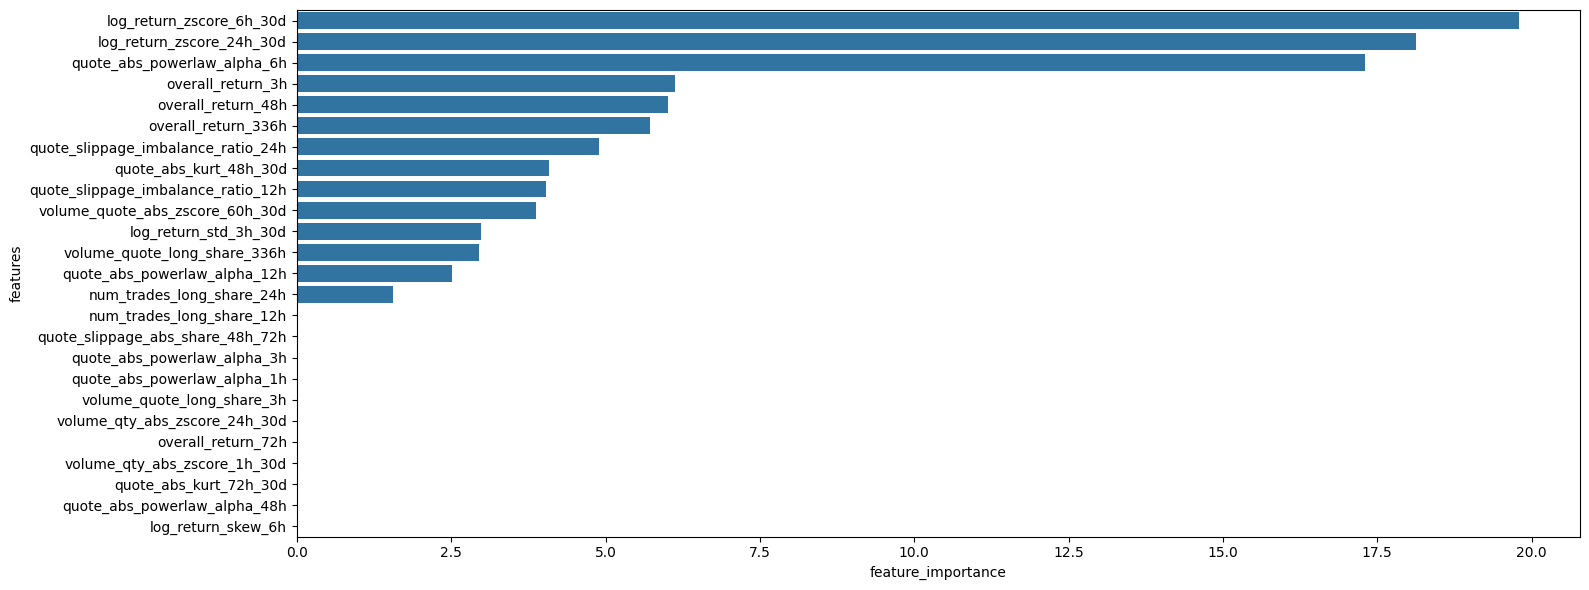

In [33]:
import seaborn as sns

df_fi = pd.DataFrame({
    "features": reg_cols,
    "feature_importance": model.feature_importances_
})

df_fi = df_fi.sort_values(by="feature_importance", ascending=False)


fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

sns.barplot(
    data=df_fi.iloc[:25], x="feature_importance", y="features", ax=ax
)

plt.tight_layout()
plt.show()

In [41]:
from sklearn.ensemble import RandomForestClassifier


def objective_rf(
    trial, df: pd.DataFrame, reg_cols: List[str], fold: TimeSeriesSplit, target: str
):

    rf = RandomForestClassifier(
         # max depth of grown trees, (it is typically better to have more of smaller trees so there is no overfit)
        max_depth=trial.suggest_int("max_depth", 2, 5),
        # number of trees grown in our ensemble
        n_estimators=trial.suggest_int("n_estimators", 100, 1000),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 15),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 2, 15),
        min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0, 0.01),
        max_samples=trial.suggest_float("max_samples", 0.5, 1), # use not all observations to avoid overfit
        criterion="gini",
        max_features="sqrt",
        class_weight="balanced"
    )
    
    val_auc_scores, train_auc_scores = [], []
    
    i = 0
    
    for train_idx, val_idx in fold.split(df[reg_cols], df[target]):
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # split data into train and validation then calculate target PR-AUC score
        rf.fit(df_train[reg_cols], df_train[target])
        # calculate PR-AUC score for both train and validation sets
        probs_train = rf.predict_proba(df_train[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(y_true=df_train[target], probas_pred=probs_train)
        train_auc_scores.append(
            auc(recalls, precisions)
        )
        
        probs_val = rf.predict_proba(df_val[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_val[target], probs_val)

        auc_score = auc(recalls, precisions)
        val_auc_scores.append(auc_score)

        trial.report(auc_score, i)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        i += 1
    
    return np.mean(val_auc_scores)

In [ ]:
study_rf = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)

study_rf.optimize(
    partial(
        objective_rf, df=df_train, 
        reg_cols=reg_cols, target="is_pumped", fold=fold
    ), 
    n_trials=10
)

In [47]:
model = RandomForestClassifier(
    criterion="gini", max_features="sqrt", class_weight="balanced",
    **study_rf.best_params
)

model.fit(df_train[reg_cols], df_train["is_pumped"])

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       max_samples=0.5504313718558707,
                       min_impurity_decrease=5.813519584456195e-05,
                       min_samples_leaf=10, min_samples_split=12,
                       n_estimators=739)

In [50]:
y_proba = model.predict_proba(df_test[reg_cols])
y_proba

array([[0.76919064, 0.23080936],
       [0.76331893, 0.23668107],
       [0.75545458, 0.24454542],
       ...,
       [0.79532485, 0.20467515],
       [0.51847698, 0.48152302],
       [0.59908896, 0.40091104]])

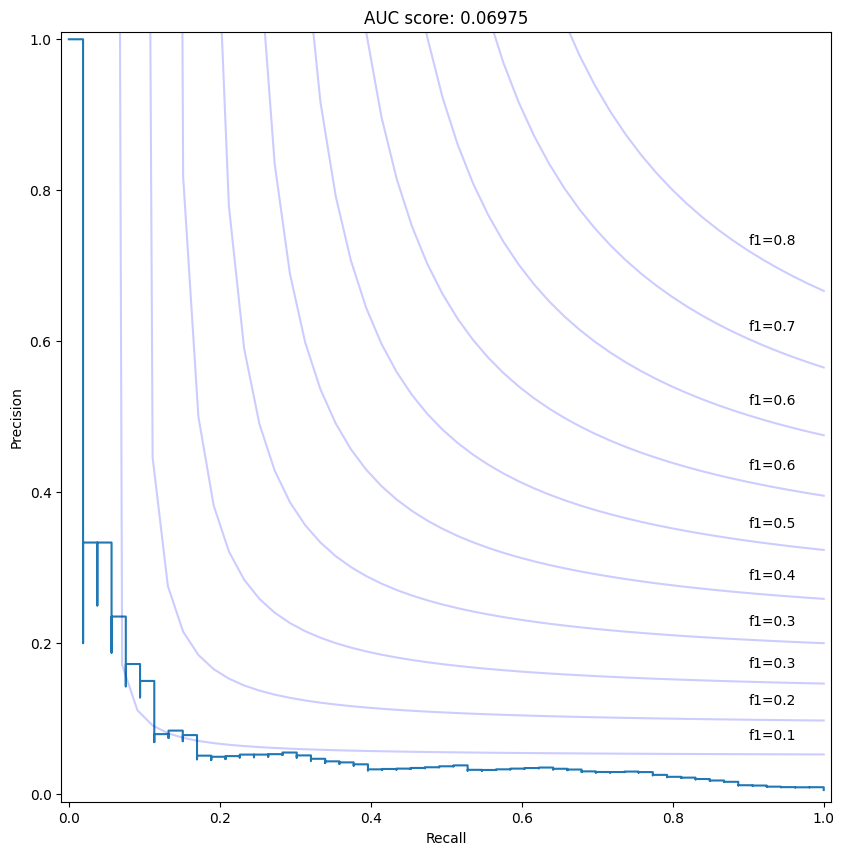

In [51]:
precision, recall, thresholds = precision_recall_curve(y_true=df_test["is_pumped"], probas_pred=y_proba[:, 1])

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

PrecisionRecallDisplay(
    precision=precision, recall=recall
).plot(ax=ax)

f_scores = np.linspace(0.1, 0.8, num=10)
lines, labels = [], []

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
    ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

plt.title(f"AUC score: {round(auc(recall, precision), 5)}")
plt.show()

In [52]:
# TOP-K metric
df_test["proba"] = y_proba[:, 1]
top_k_vals = []

for K in [1, 3, 5, 10, 20, 30]: 

    top_k: List[bool] = []

    for pump_hash, df_pump in df_test.groupby("pump_hash"):
        df_pump = df_pump.sort_values(by="proba", ascending=False)
        top_k_contains_pump: bool = df_pump.iloc[:K]["is_pumped"].any()
        top_k.append(top_k_contains_pump)

    top_k_vals.append(
        sum(top_k) / len(top_k)
    )
        
pd.DataFrame({
    "HR": [1, 3, 5, 10, 20, 30],
    "Catboost model": top_k_vals
}).set_index("HR")

,Catboost model
HR,
1,0.113208
3,0.169811
5,0.245283
10,0.396226
20,0.679245
30,0.773585
